# Pollution Dataset

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
ds = get_pollution_data_beijing().to_xarray()
ds

<xarray.Dataset>
Dimensions:    (point: 1, time: 43824)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 ... 2014-12-31T23:00:00
  * point      (point) object '1'
Data variables:
    pollution  (time, point) float64 nan nan nan nan nan ... 10.0 10.0 8.0 12.0
    dew        (time, point) int64 -21 -21 -21 -21 -20 ... -23 -22 -22 -22 -21
    temp       (time, point) float64 -11.0 -12.0 -11.0 -14.0 ... -3.0 -4.0 -3.0
    press      (time, point) float64 1.021e+03 1.02e+03 ... 1.034e+03 1.034e+03
    wnd_dir    (time, point) object 'NW' 'NW' 'NW' 'NW' ... 'NW' 'NW' 'NW' 'NW'
    wnd_spd    (time, point) float64 1.79 4.92 6.71 9.84 ... 242.7 246.7 249.8
    snow       (time, point) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    rain       (time, point) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

# Load in config file

In [4]:
cfg = Config(base_dir / "tests/testconfigs/pollution.yml")
cfg._cfg["n_epochs"] = 5
cfg._cfg["autoregressive"] = True
cfg._cfg["horizon"] = 2
cfg._cfg["seq_length"] = 48
cfg

{'autoregressive': True,
 'batch_size': 256,
 'data_dir': PosixPath('data'),
 'experiment_name': 'pollution',
 'hidden_size': 64,
 'horizon': 2,
 'input_variables': ['temp', 'wnd_spd'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'n_epochs': 5,
 'num_workers': 4,
 'optimizer': 'Adam',
 'pixel_dims': ['point'],
 'run_dir': None,
 'seed': 1234,
 'seq_length': 48,
 'target_variable': 'pollution',
 'test_end_date': Timestamp('2015-12-31 00:00:00'),
 'test_start_date': Timestamp('2014-01-01 00:00:00'),
 'train_end_date': Timestamp('2011-12-31 00:00:00'),
 'train_start_date': Timestamp('2010-01-01 00:00:00'),
 'validation_end_date': Timestamp('2013-12-31 00:00:00'),
 'validation_start_date': Timestamp('2012-01-01 00:00:00')}

# Create trainer

In [5]:
trainer = Trainer(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

** No scheduler selected ** 


In [6]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/53 [00:00<?, ?it/s]

Train Loss: 0.31
Valid Loss: 0.18


Training Epoch 3:   0%|          | 0/53 [00:00<?, ?it/s]

Train Loss: 0.19
Valid Loss: 0.16


Training Epoch 4:   0%|          | 0/53 [00:00<?, ?it/s]

Train Loss: 0.18
Valid Loss: 0.16


Training Epoch 5:   0%|          | 0/53 [00:00<?, ?it/s]

Train Loss: 0.18
Valid Loss: 0.15


Validation Epoch 5: 100%|██████████| 53/53 [00:07<00:00,  7.09it/s]

Train Loss: 0.18
Valid Loss: 0.15


# Check losses of trained model

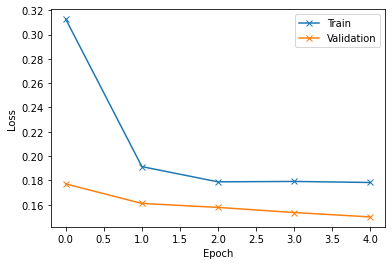

In [7]:
train_losses, valid_losses = losses
f, ax = plt.subplots()
ax.plot(train_losses, label="Train", color="C0", marker="x")
ax.plot(valid_losses, label="Validation", color="C1", marker="x")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()

# Run Evaluation

In [8]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


Test set Forward Pass: 100%|██████████| 29/29 [00:06<00:00,  4.56it/s]


<xarray.Dataset>
Dimensions:  (pixel: 1, time: 7331)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-03T01:59:44.523526144 ... 2014-12-...
    horizon  int64 2
  * pixel    (pixel) object '1_1'
Data variables:
    sim      (time, pixel) float64 248.5 188.1 106.8 10.93 ... 9.678 8.275 9.078
    obs      (time, pixel) float64 146.0 34.0 34.0 35.0 ... 8.0 10.0 10.0 8.0

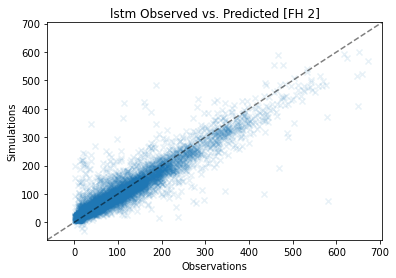

In [9]:
tester.run_test()

# The output forecasts! 

In [10]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
ds = xr.open_dataset(xr_path).isel(pixel=0).drop(["horizon", "pixel"])
ds 

<xarray.Dataset>
Dimensions:  (time: 7331)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-03T01:59:44.523526144 ... 2014-12-...
Data variables:
    sim      (time) float64 ...
    obs      (time) float64 ...

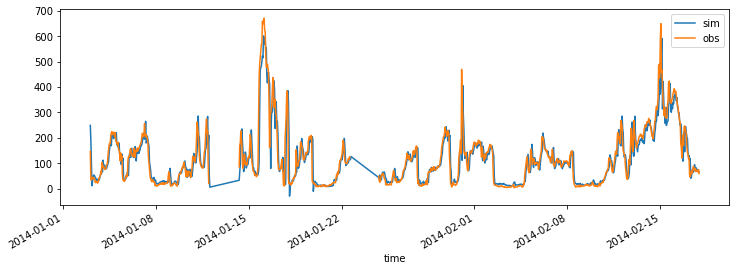

In [11]:
# .sel(time=slice("2015-01-01", "2015-02-01"))
f, ax = plt.subplots(figsize=(12, 4))
ds.isel(time=slice(0, 1000)).to_dataframe().plot(ax=ax)